# Lateral offset analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = 'sst' # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # variable of interest for post-processing
include_patterns = SST_OFFSET_DATASETS[2:]

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = f'{mouseline}_offset'
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
# Get figures PDF suffix
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
# Get trial-averaged input data directory
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 05/10/2022 19:09:13: sst_offset batch notebook started on 2022-10-05 at 19:09:13


### Input summary table figure

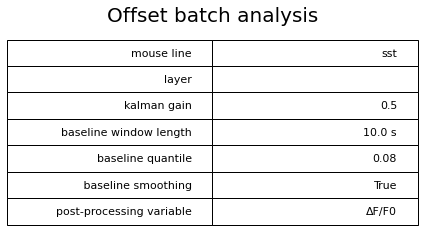

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Offset batch analysis')

## Input data

### Load data

In [6]:
# Determine what to do in case of duplicate runs
on_duplicate_runs = 'pass'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, include_patterns=include_patterns, include_mode='any',
    on_duplicate_runs=on_duplicate_runs, harmonize_runs=False, condition='offset')


 05/10/2022 19:09:13: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/sst:
 05/10/2022 19:09:13: excluding datasets not having any of the following patterns:
 - 20190601_mouse2_region1
 - 20190601_mouse7_region1
 - 20190601_mouse8_region1
 05/10/2022 19:09:13: loading trial-averaged data from 20190601_mouse2_region1.h5
 05/10/2022 19:09:13: loading trial-averaged data from 20190601_mouse7_region1.h5
 05/10/2022 19:09:13: loading trial-averaged data from 20190601_mouse8_region1.h5
 05/10/2022 19:09:13: gathering dataset IDs...
 05/10/2022 19:09:13: duplicated runs in 20190601_mouse7_region1:
run
4    0.0x_0.0y
5    0.0x_0.0y
Name: offset (mm), dtype: object
 05/10/2022 19:09:13: duplicated runs in 20190601_mouse8_region1:
run
4    0.0x_0.0y
5    0.0x_0.0y
Name: offset (mm), dtype: object
 05/10/2022 19:09:13: sorting dataset indexes...
 05/10/2022 19:09:14: adding post-stim avg Z(ΔF/F0) - pre-stim av

### Breakdown per mouse region, cell maps & filter out datasets

 05/10/2022 19:09:15: extracting timeseries and stats from data...
 05/10/2022 19:09:15: plotting cells map color-coded by response type...
 05/10/2022 19:09:15: extracting responses types per ROI...
 05/10/2022 19:09:16: plotting cells map color-coded by response type...
 05/10/2022 19:09:16: extracting responses types per ROI...
 05/10/2022 19:09:17: plotting cells map color-coded by response type...
 05/10/2022 19:09:17: extracting responses types per ROI...
 05/10/2022 19:09:17: setting minimum cell count of 101 as inclusion criterion
 05/10/2022 19:09:17: ['20190808_mouse6_region1'] datasets not found -> ignoring
 05/10/2022 19:09:17: did not find any datasets to exclude


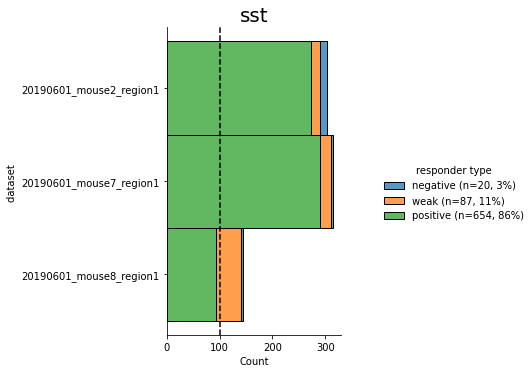

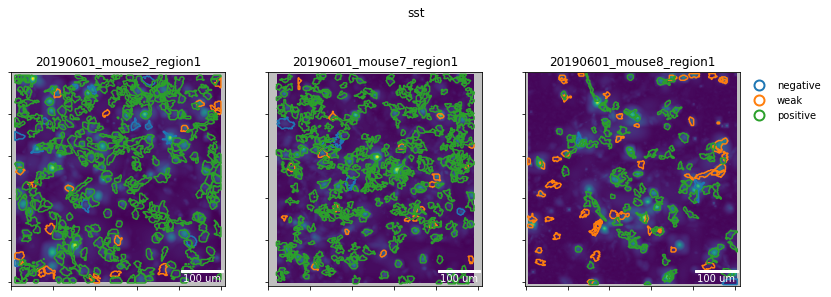

In [7]:
logger.info('extracting timeseries and stats from data...')
timeseries, stats, ROI_masks, map_ops = data['timeseries'], data['stats'], data['ROI_masks'], data['map_ops']

# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = int(np.round(MIN_CELL_DENSITY[mouseline] * area))

# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, countref=min_cell_count,
    title=mouseline)

figs['cellmaps'] = plot_cell_maps(
        ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

# Idendify datasets with a low overall cell count
logger.info(f'setting minimum cell count of {min_cell_count} as inclusion criterion')
cells = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = cells.groupby(Label.DATASET).count().iloc[:, 0].rename('cell count')
weaks = cells.loc[cells[Label.ROI_RESP_TYPE] == 'weak']
weakcounts = weaks.groupby(Label.DATASET).count().iloc[:, 0].rename('weak count')
pctresp = (1 - (weakcounts / cellcounts)) * 100
count_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()
count_exclude = []
# Manual exclusions
manual_exclude = {
    'line3': [], #'20191109_mouse7_region2'
    'sst': ['20190808_mouse6_region1'],
    'pv': []
}[mouseline]

# Exclude them
timeseries, stats = exclude_datasets(timeseries, stats, count_exclude + manual_exclude)

### Add transducer location info to stats

In [8]:
logger.info('adding parsed 2D offset info to stats...')
offsets_2d = get_offset_complex(stats)
stats['xoff (mm)'] = offsets_2d.apply(np.real)
stats['yoff (mm)'] = offsets_2d.apply(np.imag)

 05/10/2022 19:09:20: adding parsed 2D offset info to stats...


### Plot response strength vs. XY offset

 05/10/2022 19:09:20: restricting responder type to "positive"
 05/10/2022 19:09:20: grouping stats by dataset...
 05/10/2022 19:09:20: plotting map of "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. XY offset...
 05/10/2022 19:09:21: found max "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" values at offset coordinates:
                         xoff (mm)  yoff (mm)
dataset                                      
20190601_mouse2_region1        0.5        0.0
20190601_mouse7_region1       -0.5        0.0
20190601_mouse8_region1       -1.0        0.0


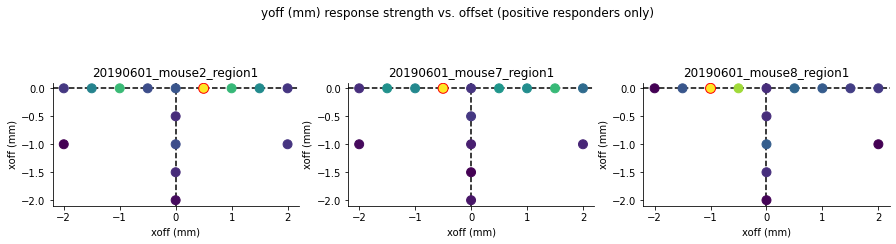

In [9]:
# Filters: focus on positive responders
filters = {Label.ROI_RESP_TYPE: 'positive'}

# Keys for coordinates and output metrics of interest
xykeys = ['xoff (mm)', 'yoff (mm)']
outkey = get_change_key(ykey_postpro)

# Plot map of response strength across XY offsets 
figs['resp_vs_offset_loc'], max_resp_offset_coords = plot_stat_vs_offset_map(
    stats, *xykeys, outkey, filters=filters, title='positive responders only')

### Correct offset origins for each dataset (max response at origin)

 05/10/2022 19:09:22: restricting responder type to "positive"
 05/10/2022 19:09:22: grouping stats by dataset...
 05/10/2022 19:09:22: plotting map of "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. XY offset...
 05/10/2022 19:09:22: found max "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" values at offset coordinates:
                         corrected xoff (mm)  corrected yoff (mm)
dataset                                                          
20190601_mouse2_region1                  0.0                  0.0
20190601_mouse7_region1                  0.0                  0.0
20190601_mouse8_region1                  0.0                  0.0


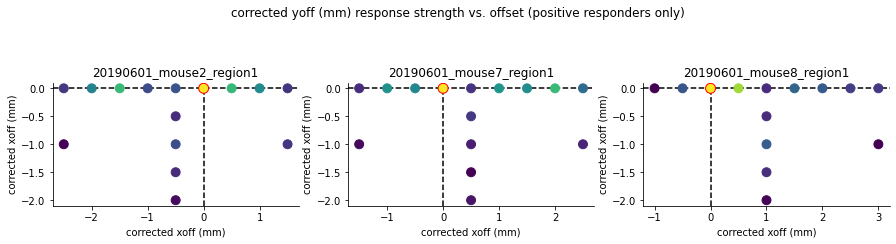

In [10]:
# Apply corrections
for k in xykeys:
    stats[f'corrected {k}'] = stats[k] - max_resp_offset_coords[k]

# Plot map of response strength across corrected XY offsets 
corrected_xykeys = [f'corrected {x}' for x in xykeys]
figs['resp_vs_offset_loc_corrected'], _ = plot_stat_vs_offset_map(
    stats, *corrected_xykeys, outkey, filters=filters, title='positive responders only')

### Plot response strength vs. normalized offset distance

 05/10/2022 19:09:23: plotting "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. "corrected offset (mm)" across datasets & responder types...
 05/10/2022 19:09:25: restricting to responders only
 05/10/2022 19:09:25: plotting "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. "corrected offset (mm)" across datasets...
 05/10/2022 19:09:25: plotting "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. "corrected offset (mm)" aggregate...


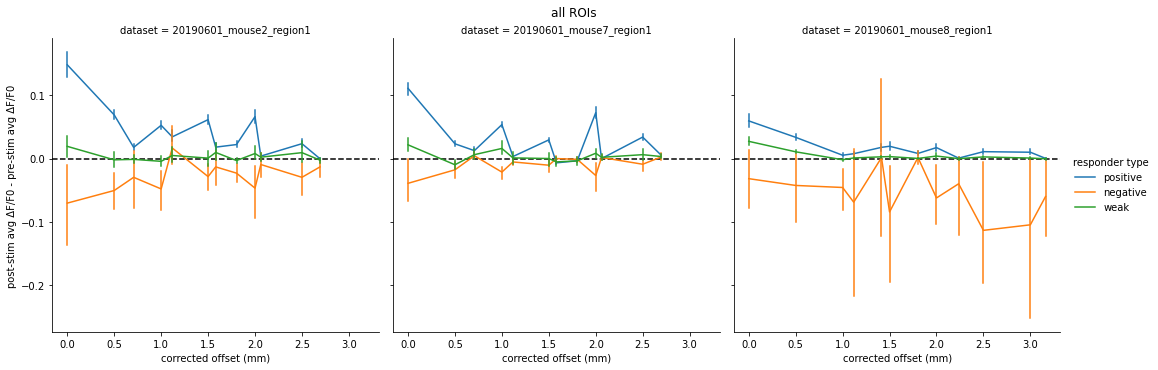

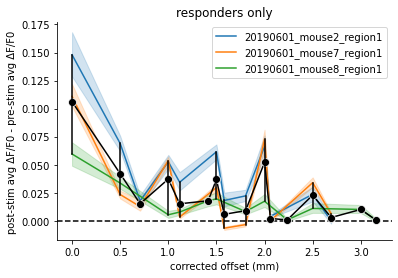

In [11]:
# Compute (corrected) offset distance as XY norm
dkey = f'corrected {Label.OFFSET}'
stats[dkey] = np.linalg.norm(stats[corrected_xykeys], axis=1)

# Plot response strength vs. distance
figs['resp_vs_offset_all'], figs['resp_vs_offset_pos'] = plot_stat_vs_offset_distance(
    stats, dkey, outkey)

### Plot response strength rounded normalized distances

 05/10/2022 19:09:26: plotting "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. "rounded corrected offset (mm)" across datasets & responder types...
 05/10/2022 19:09:27: restricting to responders only
 05/10/2022 19:09:27: plotting "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. "rounded corrected offset (mm)" across datasets...
 05/10/2022 19:09:27: plotting "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. "rounded corrected offset (mm)" aggregate...


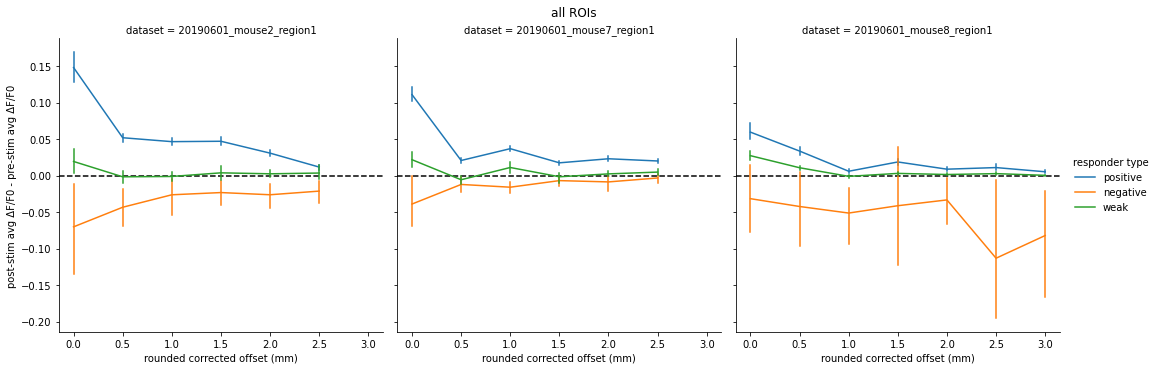

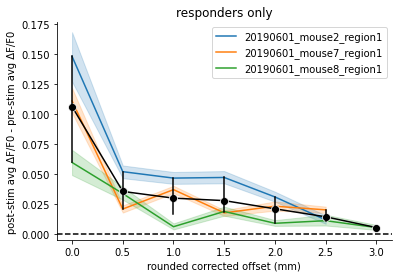

In [12]:
# Compute clustered distance
rounded_dkey = f'rounded {dkey}'
stats[rounded_dkey] = stats[dkey].apply(round_to_base)

# Plot response strength vs. clustered distance
figs['resp_vs_rounded_offset_all'], figs['resp_vs_rounded_offset_pos'] = plot_stat_vs_offset_distance(
    stats, rounded_dkey, outkey)

### Plot responders traces vs offset

 05/10/2022 19:18:52: assembling plot data...
 05/10/2022 19:18:53: restricting to positive responders...
 05/10/2022 19:18:53: adding time info to table...
 05/10/2022 19:18:53: plotting responders traces across offset & datasets...
 05/10/2022 19:18:57: plotting aggregate responders traces across offset...
 05/10/2022 19:18:57: adding time info to table...


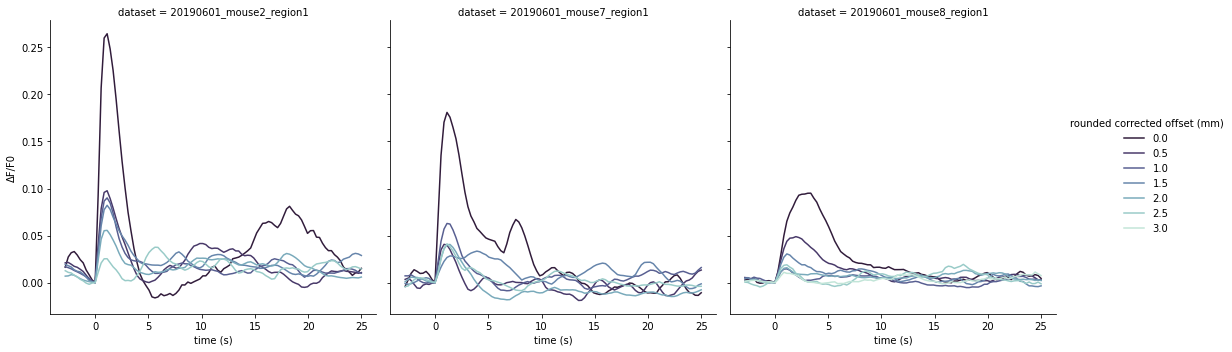

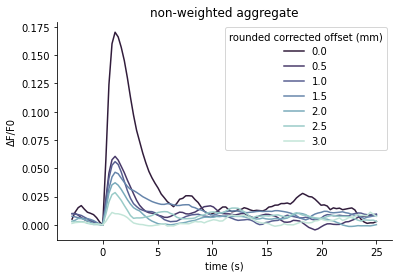

In [24]:
# Get plot data
logger.info('assembling plot data...')
pltdata = expand_and_add(stats[[Label.ROI_RESP_TYPE, rounded_dkey]], timeseries.copy())
# Restrict to positive responders
logger.info('restricting to positive responders...')
pltdata = pltdata[pltdata[Label.ROI_RESP_TYPE] == 'positive']
# Add time
fps = get_singleton(stats, Label.FPS)
pltdata = add_time_to_table(pltdata, fps=fps)

# Plot parameters
palette = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
# palette = sns.color_palette('dark:C0_r', as_cmap=True)
ci = None

# Plot response traces vs. offset for each dataset
logger.info('plotting responders traces across offset & datasets...')
fg = sns.relplot(
    data=pltdata, x=Label.TIME, y=ykey_postpro, kind='line',
    hue=rounded_dkey, col=Label.DATASET, ci=ci, palette=palette)
figs['traces_vs_offset_per_dataset'] = fg.figure

# Plot non-weighted aggregate response traces vs. offset
logger.info('plotting aggregate responders traces across offset...')
aggdata = pltdata.groupby([Label.DATASET, Label.FRAME, rounded_dkey]).mean()
del aggdata[Label.TIME]
aggdata = add_time_to_table(aggdata, fps=fps)
figs['traces_vs_offset_agg'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('non-weighted aggregate')
sns.lineplot(
    data=aggdata, x=Label.TIME, y=ykey_postpro, ax=ax,
    hue=rounded_dkey, ci=ci, palette=palette);

### Save figures

In [25]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 05/10/2022 19:19:30: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.10.05/figs_sst_offset_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 11/11 [00:01<00:00,  7.80it/s]


### Notify upon completion

In [15]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 05/10/2022 19:09:35: sst batch notebook completed in 0:00:22.160794 s
